In [1]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import OneHotEncoder
%matplotlib inline

## Get data sample

In [3]:
data = pd.read_csv('kc_house_data.csv')


In [4]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   waterfront     21597 non-null  int64  
 7   view           21597 non-null  int64  
 8   condition      21597 non-null  int64  
 9   grade          21597 non-null  int64  
 10  sqft_above     21597 non-null  int64  
 11  sqft_basement  21597 non-null  int64  
 12  zipcode        21597 non-null  int64  
 13  lat            21597 non-null  float64
 14  long           21597 non-null  float64
 15  sqft_living15  21597 non-null  int64  
 16  sqft_lot15     21597 non-null  int64  
dtypes: float64(5), int64(12)
memory usage: 2.8 MB


In [6]:
data.drop(['id'], axis=1, inplace = True)

### Example of feature creation (for illustration)

In [ ]:
df = data['date'].apply(lambda x: x.split('/')[2])

In [ ]:
data.insert(1,"sales_year",df)

In [ ]:
data.drop(['date'],axis=1, inplace=True)

In [ ]:
data['sales_year']=data['sales_year'].astype('int')

In [ ]:
data['age_of_building']=data['sales_year'] - data['yr_built']


In [ ]:
data['years_from_ren']=0
data.loc[data['yr_renovated']>0,'years_from_ren'] = data['sales_year']-data['yr_renovated']

In [7]:
data.drop(['yr_built','yr_renovated', 'date'],axis=1, inplace=True)

#### Define categorical and numerical variables

In [9]:
data['zipcode'] = data['zipcode'].astype('object')

In [10]:
data['waterfront'] = data['waterfront'].astype('object')

In [11]:
data['condition'] = data['condition'].astype('object')
data['view'] = data['view'].astype('object')
data['zipcode']=data['zipcode'].astype('object')

viewing value counts to see if could be grouped 

In [12]:
data['view'].value_counts()

view
0    19475
2      961
3      510
1      332
4      319
Name: count, dtype: int64

In [13]:
data['condition'].value_counts()

condition
3    14020
4     5677
5     1701
2      170
1       29
Name: count, dtype: int64

In [14]:
cat = ['view', 'condition', 'zipcode', 'waterfront']

split for categorical and numerical values

In [15]:
data_cat = data[cat]

In [57]:
data_num = data.select_dtypes(include=['int64','float64'])

### Get descriptive statistic

looking at price as dependant values to look at how other variables vary, needing to remove outliers since it effects linear model

In [58]:
data_num.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
price,21597.0,540296.57,367368.14,78000.00,322000.00,450000.00,645000.00,7700000.00
bedrooms,21597.0,3.37,0.93,1.00,3.00,3.00,4.00,33.00
bathrooms,21597.0,2.12,0.77,0.50,1.75,2.25,2.50,8.00
sqft_living,21597.0,2080.32,918.11,370.00,1430.00,1910.00,2550.00,13540.00
sqft_lot,21597.0,15099.41,41412.64,520.00,5040.00,7618.00,10685.00,1651359.00
floors,21597.0,1.49,0.54,1.00,1.00,1.50,2.00,3.50
grade,21597.0,7.66,1.17,3.00,7.00,7.00,8.00,13.00
sqft_above,21597.0,1788.60,827.76,370.00,1190.00,1560.00,2210.00,9410.00
sqft_basement,21597.0,291.73,442.67,0.00,0.00,0.00,560.00,4820.00
lat,21597.0,47.56,0.14,47.16,47.47,47.57,47.68,47.78


In [59]:
# quantile 0.9
Q90 = data_num.quantile(0.9)

In [20]:
Q90.T

price            887000.0000
bedrooms              4.0000
bathrooms             3.0000
sqft_living        3254.0000
sqft_lot          21371.6000
floors                2.0000
grade                 9.0000
sqft_above         2950.0000
sqft_basement       970.0000
lat                  47.7279
long               -122.0220
sqft_living15      2930.0000
sqft_lot15        17822.0000
Name: 0.9, dtype: float64

In [60]:
data_cat.describe().T

,count,unique,top,freq
view,21597,5,0,19475
condition,21597,5,3,14020
zipcode,21597,70,98103,602
waterfront,21597,2,0,21434


##Exploratory Data Analysis

In [22]:
sns.set_palette("GnBu_d")
sns.set_style('whitegrid')

### Example of data visualisation to detect the possable relationships, form and outliers

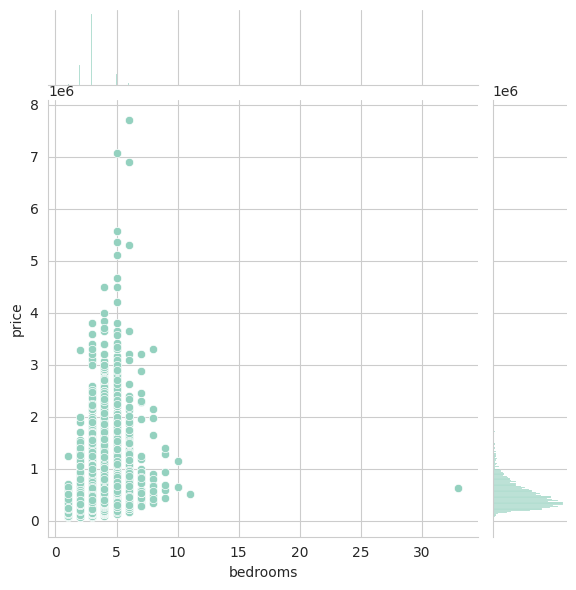

In [23]:
sns.jointplot(x = 'bedrooms', y = 'price', data = data)

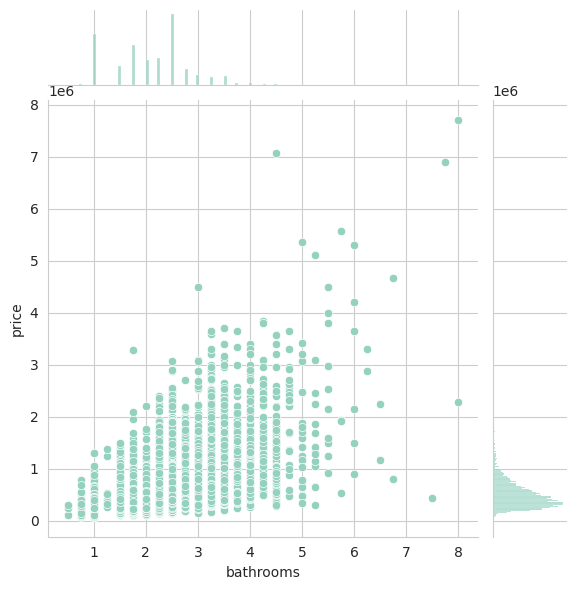

In [24]:
sns.jointplot(x = 'bathrooms', y = 'price', data = data)

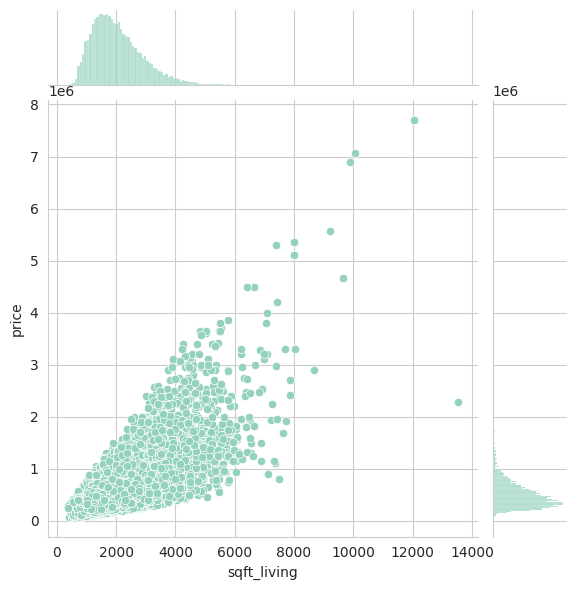

In [25]:
sns.jointplot(x = 'sqft_living', y = 'price', data = data)

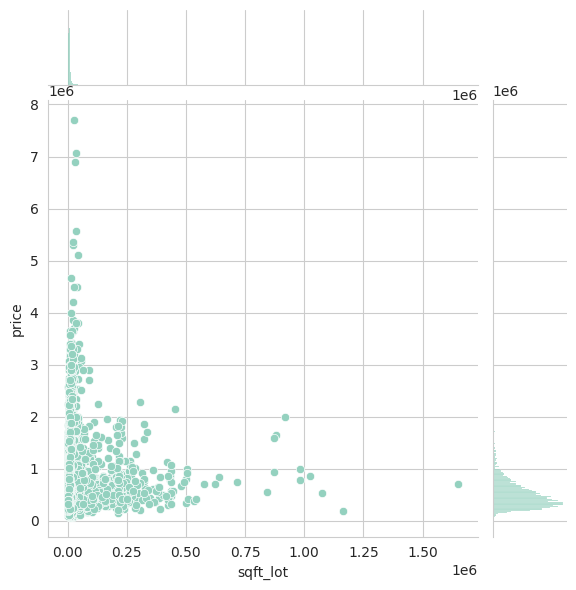

In [26]:
sns.jointplot(x = 'sqft_lot', y = 'price', data = data)

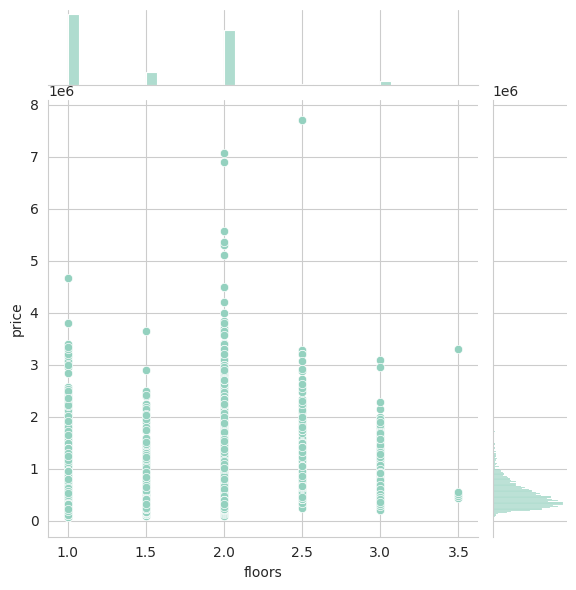

In [27]:
sns.jointplot(x = 'floors', y = 'price', data = data)

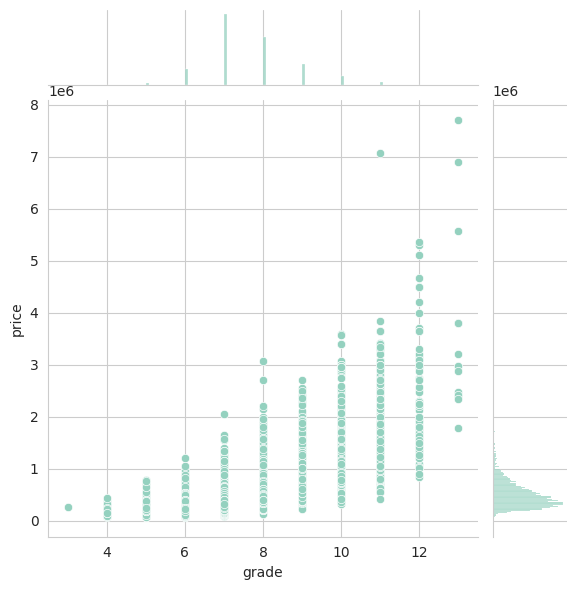

In [28]:
sns.jointplot(x = 'grade', y = 'price', data = data)

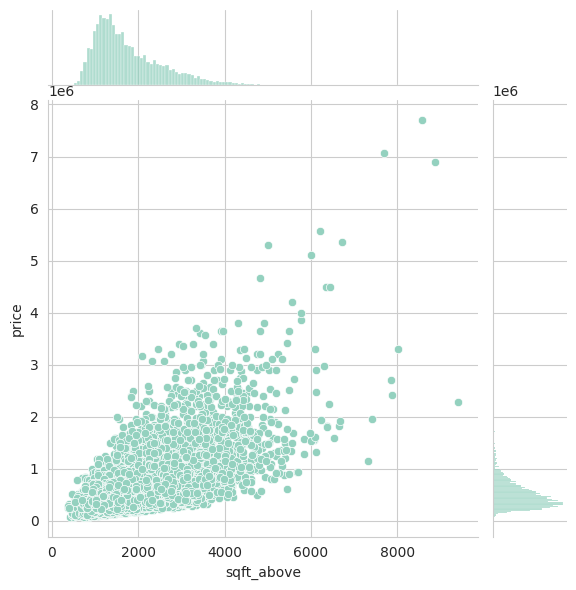

In [29]:
sns.jointplot(x = 'sqft_above', y = 'price',data = data)

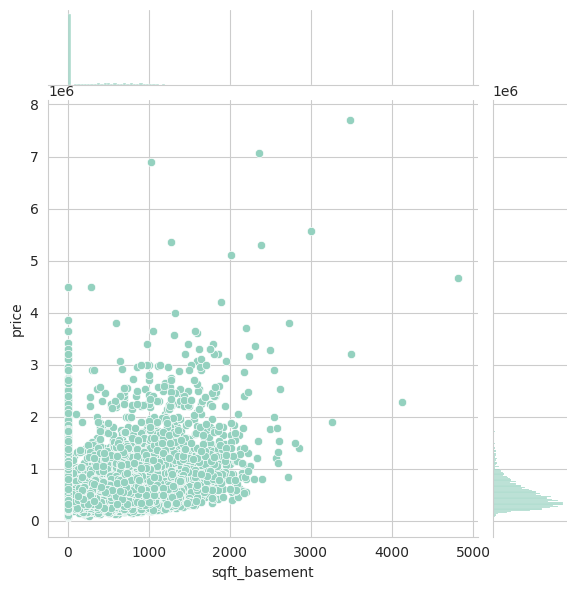

In [30]:
sns.jointplot(x = 'sqft_basement', y = 'price', data = data)

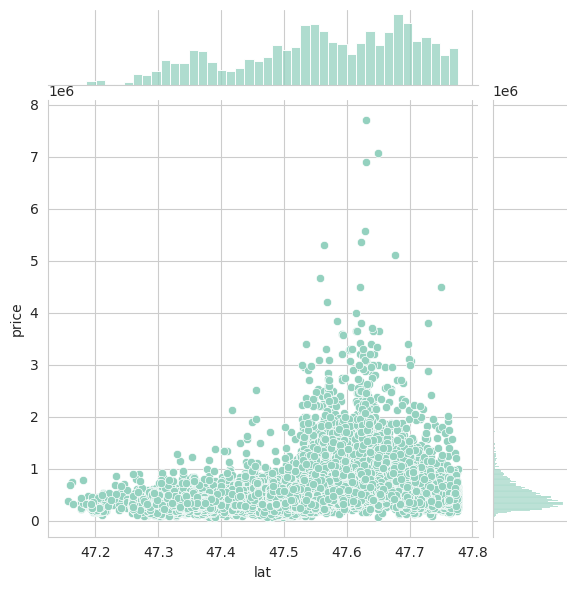

In [31]:
sns.jointplot(x = 'lat', y = 'price', data = data)

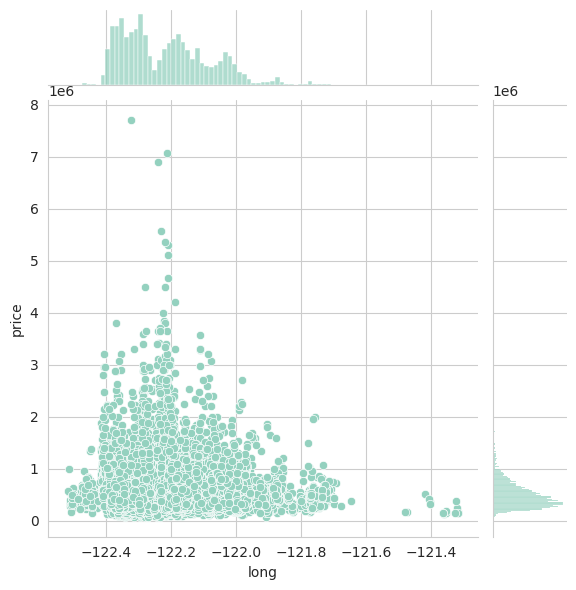

In [32]:
sns.jointplot(x = 'long', y = 'price', data = data)

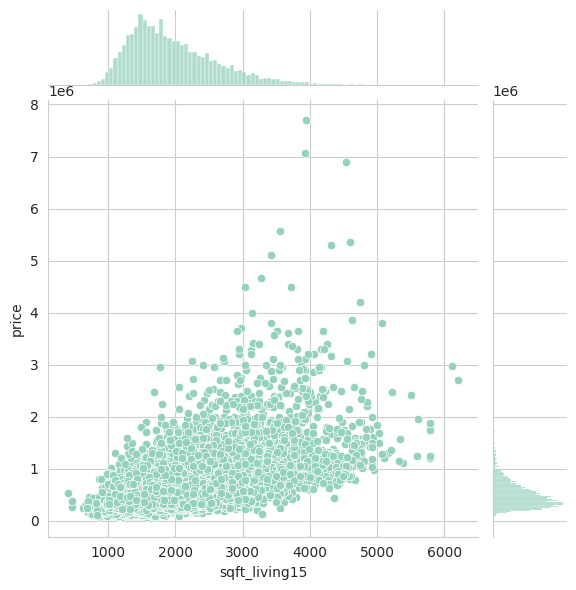

In [33]:
sns.jointplot(x = 'sqft_living15', y = 'price', data = data)

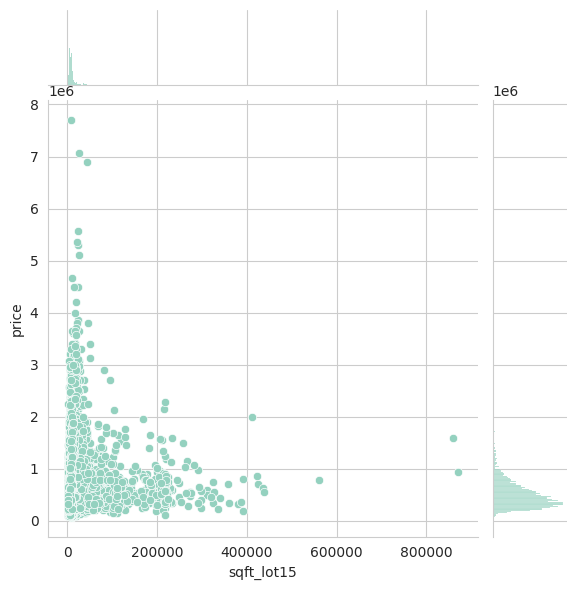

In [34]:
sns.jointplot(x = 'sqft_lot15', y = 'price', data = data)

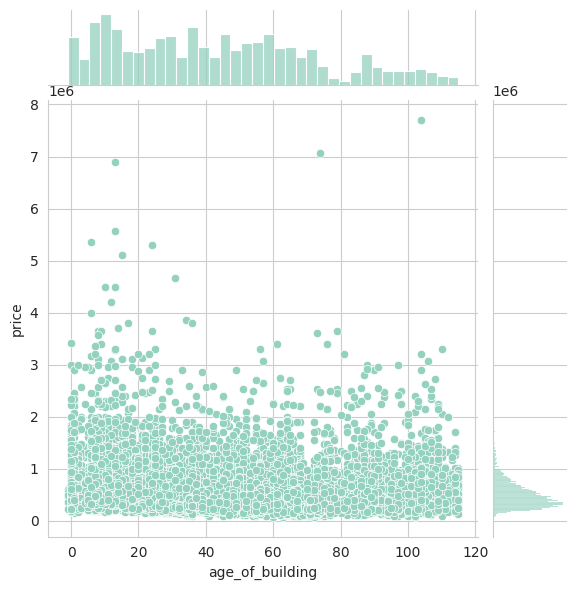

In [ ]:
#sns.jointplot(x = 'age_of_building', y = 'price', data = data)

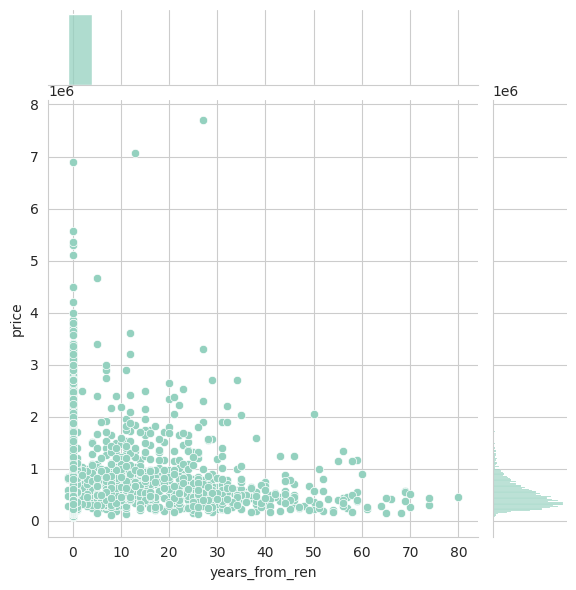

In [ ]:
#sns.jointplot(x = 'years_from_ren', y = 'price', data = data)

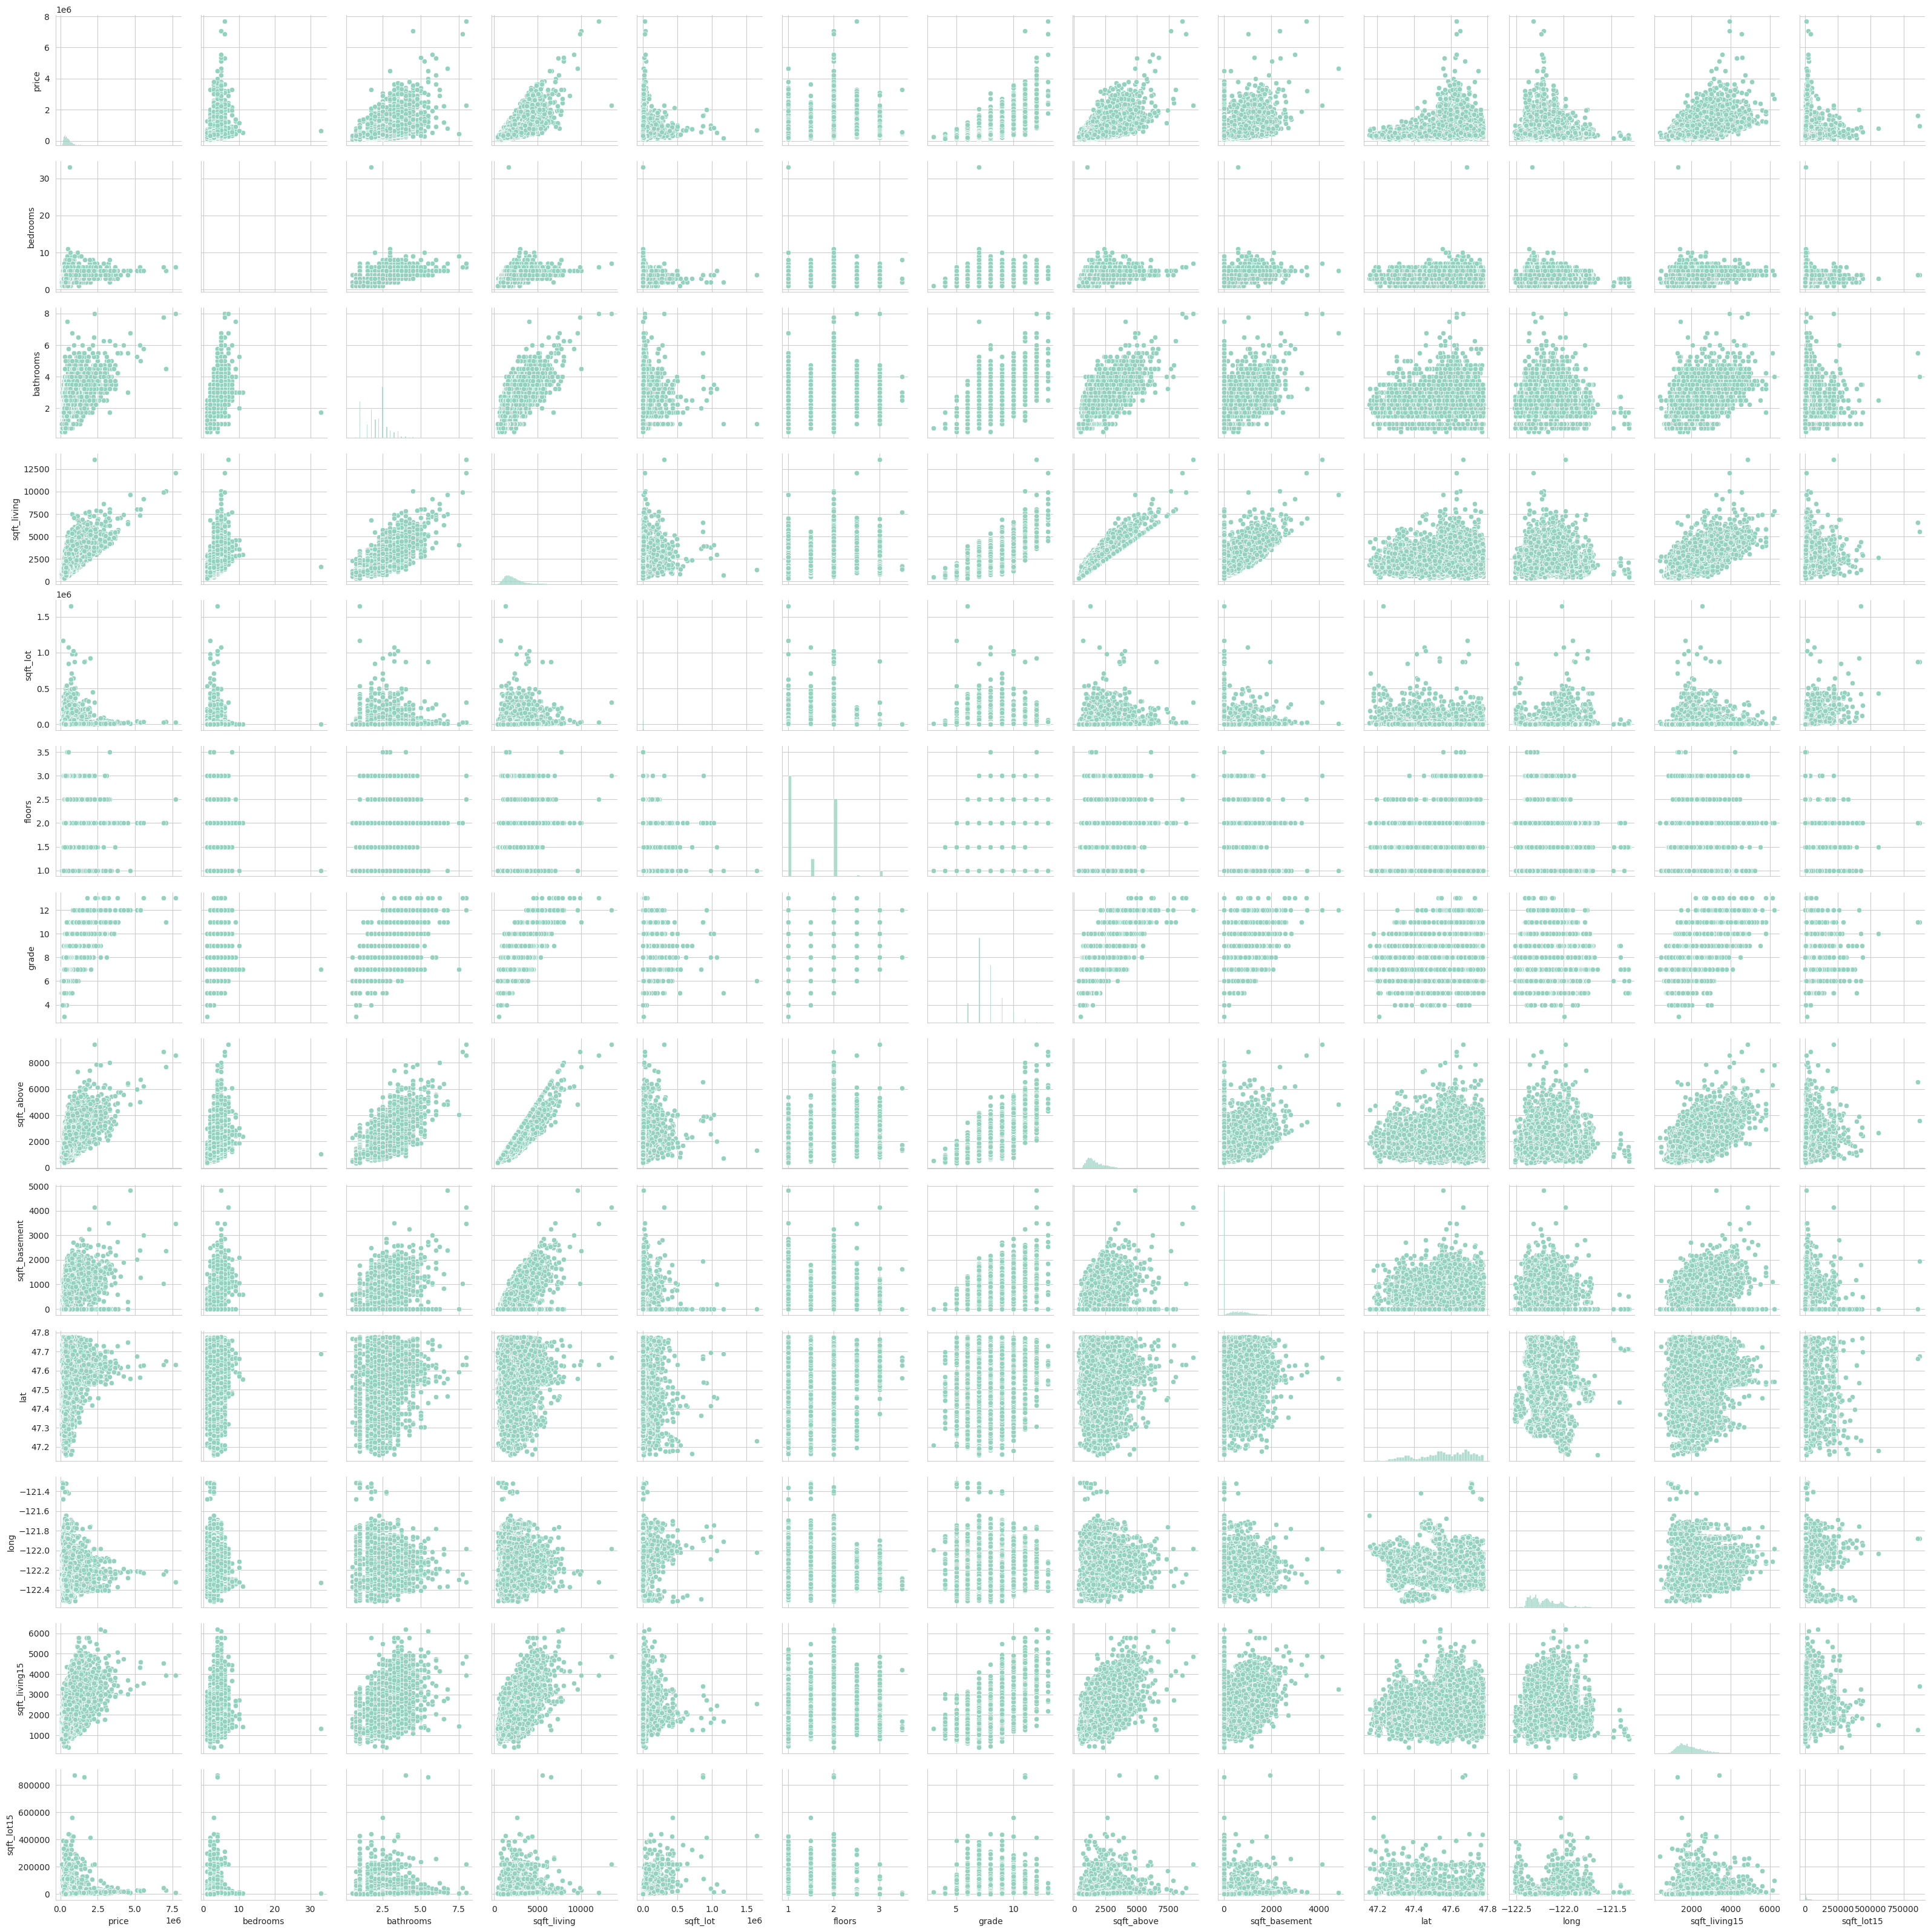

In [35]:
sns.pairplot(data_num)

### Cleaning from outliers

In [61]:
data_num.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'grade', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15',
       'sqft_lot15'],
      dtype='object')

<Axes: >

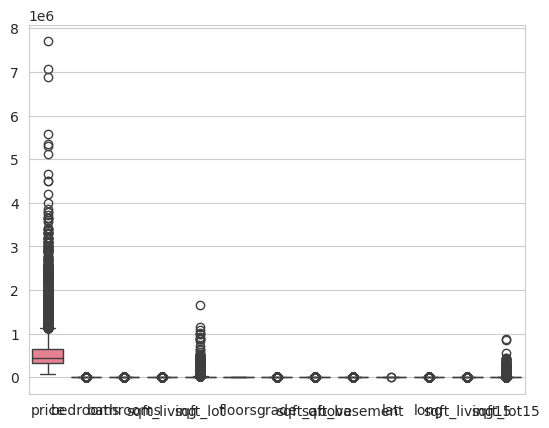

In [62]:
sns.boxplot(data_num)

In [63]:
q=data_num.quantile(0.90)
q

price            887000.0000
bedrooms              4.0000
bathrooms             3.0000
sqft_living        3254.0000
sqft_lot          21371.6000
floors                2.0000
grade                 9.0000
sqft_above         2950.0000
sqft_basement       970.0000
lat                  47.7279
long               -122.0220
sqft_living15      2930.0000
sqft_lot15        17822.0000
Name: 0.9, dtype: float64

In [64]:
data_cleaned = data

In [65]:
num_col = data_num.columns

In [68]:
data_cleaned = data_cleaned[data_cleaned['price']<q[0]]

<Axes: >

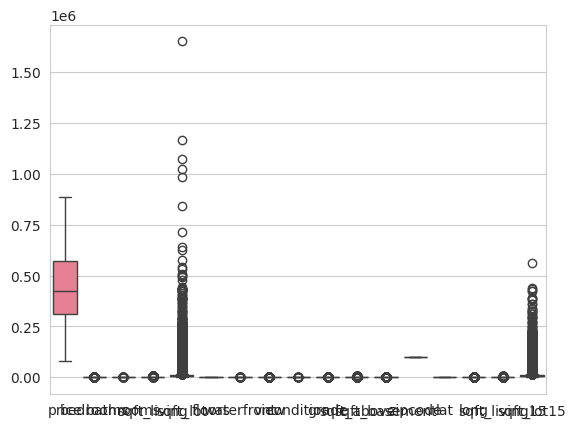

In [70]:
sns.boxplot(data_cleaned)

In [71]:
q=data_num.quantile(0.90)
q

price            887000.0000
bedrooms              4.0000
bathrooms             3.0000
sqft_living        3254.0000
sqft_lot          21371.6000
floors                2.0000
grade                 9.0000
sqft_above         2950.0000
sqft_basement       970.0000
lat                  47.7279
long               -122.0220
sqft_living15      2930.0000
sqft_lot15        17822.0000
Name: 0.9, dtype: float64

In [72]:
data_cleaned = data_cleaned[data_cleaned['sqft_lot']<q[4]]

<Axes: >

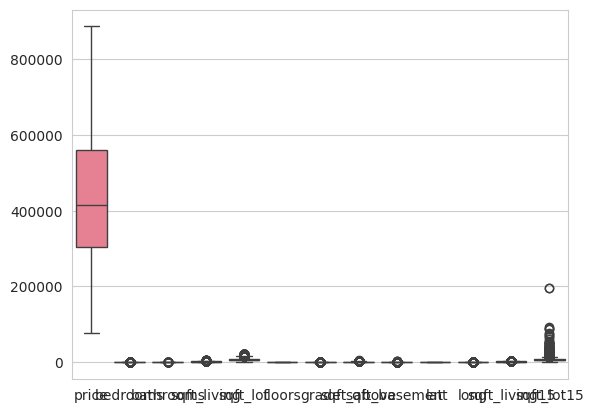

In [73]:
sns.boxplot(data_cleaned[num_col])

In [ ]:
#data_cleaned = data_cleaned[data_cleaned['sqft_lot15']<q[13]]

<Axes: >

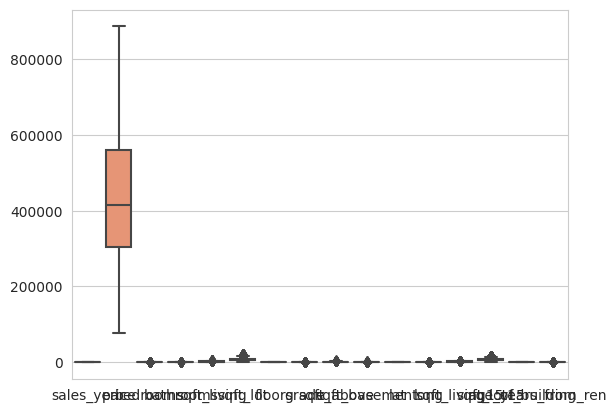

In [ ]:
sns.boxplot(data_cleaned[num_col])

<Axes: ylabel='price'>

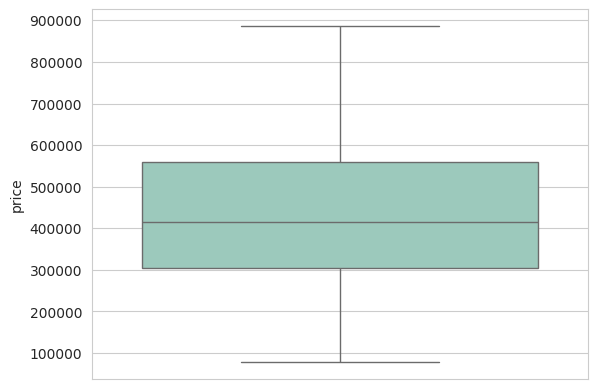

In [74]:
sns.boxplot(data=data_cleaned['price'])

<Axes: >

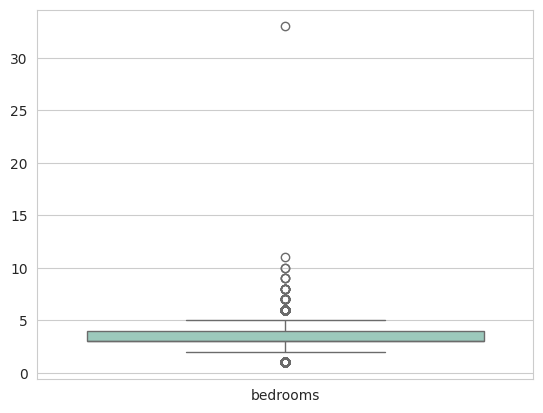

In [75]:
sns.boxplot(data=data_cleaned[['bedrooms']])

<Axes: >

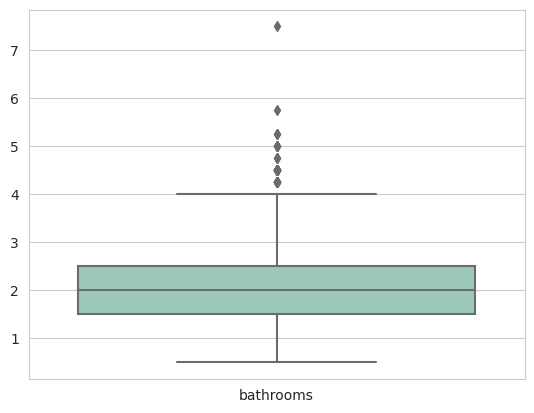

In [ ]:
sns.boxplot(data=data_cleaned[['bathrooms']])

<Axes: >

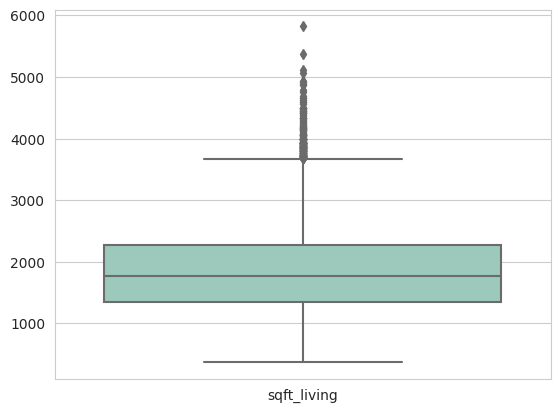

In [ ]:
sns.boxplot(data=data_cleaned[['sqft_living']])

scale here

### Get correlation matrix

In [76]:
data_num = data_cleaned[num_col]

<Axes: >

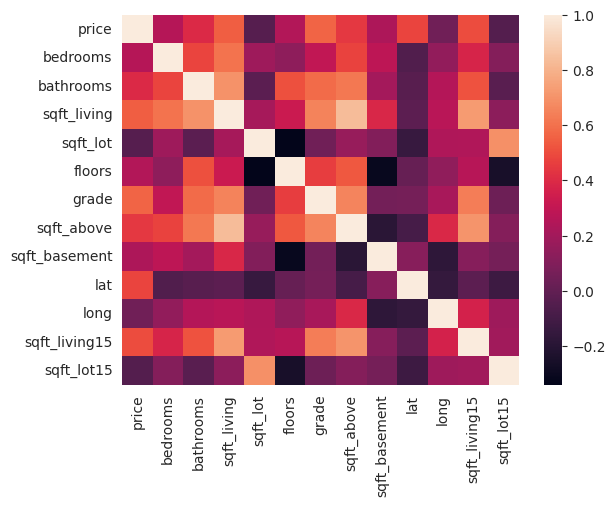

In [77]:
sns.heatmap(data_num.corr())

better visualization

<Axes: >

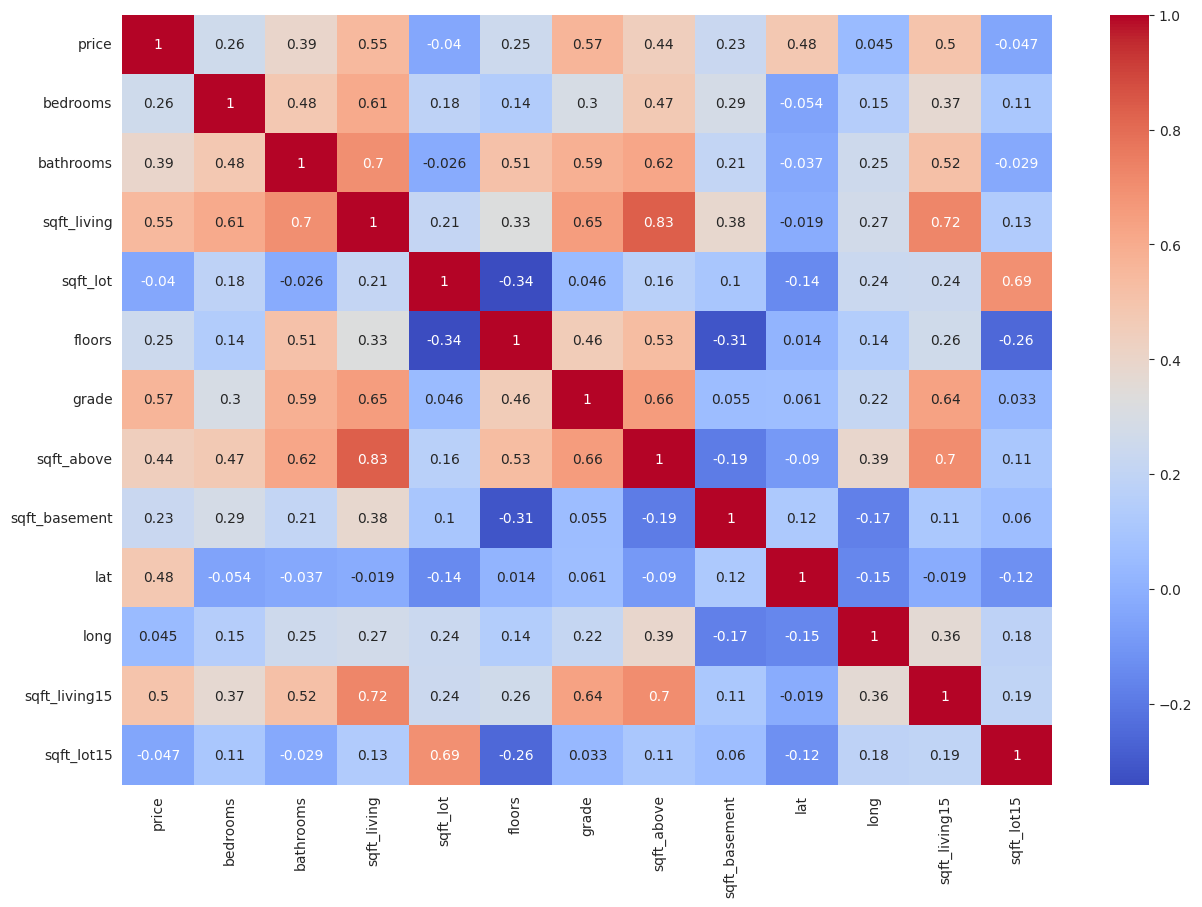

In [78]:
from typing import ChainMap
CM = data_num.corr()
plt.figure(figsize=(15,10))
sns.heatmap(CM, annot=True, cmap='coolwarm')

In [79]:
data_cat.columns

Index(['view', 'condition', 'zipcode', 'waterfront'], dtype='object')

https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html


In [80]:
V = pd.get_dummies(data_cleaned['view'], drop_first=False)
for i in range(len(V.columns)):
 V.rename(columns={V.columns[i]:'View'+ str(i)}, inplace=True)

C = pd.get_dummies(data_cleaned['condition'], drop_first=False)
for i in range(len(C.columns)):
  C.rename(columns={C.columns[i]:'Condition'+str(i)}, inplace=True)

#Z = pd.get_dummies(data_cleaned['zipcode'], drop_first=False)

W = pd.get_dummies(data_cleaned['waterfront'], drop_first = False)
for i in range(len(W.columns)):
  W.rename(columns={W.columns[i]: 'waterfront'+str(i)}, inplace = True)

In [81]:
data_cleaned.drop(['view', 'condition', 'zipcode', 'waterfront'],axis=1, inplace=True)

In [82]:
data_cleaned = pd.concat([data_cleaned, V, C, W], axis=1)

In [83]:
data_cleaned.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,sqft_basement,lat,...,View2,View3,View4,Condition0,Condition1,Condition2,Condition3,Condition4,waterfront0,waterfront1
0,221900.0,3,1.00,1180,5650,1.0,7,1180,0,47.5112,...,False,False,False,False,False,True,False,False,True,False
1,538000.0,3,2.25,2570,7242,2.0,7,2170,400,47.7210,...,False,False,False,False,False,True,False,False,True,False
2,180000.0,2,1.00,770,10000,1.0,6,770,0,47.7379,...,False,False,False,False,False,True,False,False,True,False
3,604000.0,4,3.00,1960,5000,1.0,7,1050,910,47.5208,...,False,False,False,False,False,False,False,True,True,False
4,510000.0,3,2.00,1680,8080,1.0,8,1680,0,47.6168,...,False,False,False,False,False,True,False,False,True,False


In [101]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17682 entries, 0 to 21596
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          17682 non-null  float64
 1   bedrooms       17682 non-null  int64  
 2   bathrooms      17682 non-null  float64
 3   sqft_living    17682 non-null  int64  
 4   sqft_lot       17682 non-null  int64  
 5   floors         17682 non-null  float64
 6   grade          17682 non-null  int64  
 7   sqft_above     17682 non-null  int64  
 8   sqft_basement  17682 non-null  int64  
 9   lat            17682 non-null  float64
 10  long           17682 non-null  float64
 11  sqft_living15  17682 non-null  int64  
 12  sqft_lot15     17682 non-null  int64  
 13  View0          17682 non-null  int64  
 14  View1          17682 non-null  int64  
 15  View2          17682 non-null  int64  
 16  View3          17682 non-null  int64  
 17  View4          17682 non-null  int64  
 18  Condition0 

In [99]:
boolean_columns = data_cleaned.select_dtypes(include='bool').columns
print(boolean_columns)

Index(['View0', 'View1', 'View2', 'View3', 'View4', 'Condition0', 'Condition1',
       'Condition2', 'Condition3', 'Condition4', 'waterfront0', 'waterfront1'],
      dtype='object')


change booleans to values for sklearn

In [100]:
data_cleaned[boolean_columns] = data_cleaned[boolean_columns].astype(int)

In [102]:
Y = data_cleaned['price']
X = data_cleaned.drop(['price'],axis=1)

In [103]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10)

##Training a Linear Regression Model

statsmodel is additional model for linear regression

In [104]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

###Creat an instance on LinearRegresison() model named lm

In [105]:
lm = LinearRegression()

#### Train/fit lm on the training data

In [106]:
lm.fit(X_train, y_train)

LinearRegression()

###Print out the coefficients of the model

In [107]:
print('Coefficients: \n', lm.coef_)

Coefficients: 
 [-2.68576818e+03 -7.34801405e+03  5.51103346e+01 -3.87868163e+00
 -6.75061244e+03  5.39396815e+04  3.09204292e+01  2.41899054e+01
  5.65285367e+05 -3.54941233e+04  4.92700178e+01 -1.99102223e+00
 -6.66513177e+04  1.15278588e+04 -5.33634245e+03  4.83758897e+03
  5.56222124e+04 -4.16106011e+04 -2.11145980e+04 -1.95982436e+04
  2.41573754e+04  5.81660674e+04 -9.66833990e+04  9.66833990e+04]


In [108]:
coeffecients = pd.DataFrame(lm.coef_, X.columns)
coeffecients.columns = ['Coeffecient']
coeffecients

,Coeffecient
bedrooms,-2685.768178
bathrooms,-7348.014054
sqft_living,55.110335
sqft_lot,-3.878682
floors,-6750.612435
grade,53939.681470
sqft_above,30.920429
sqft_basement,24.189905
lat,565285.366819
long,-35494.123340


logic of coefficients may not make sense, more bed and bath rooms should increase price

### Predicting Test Data

In [109]:
predictions = lm.predict( X_test)

Text(0, 0.5, 'Predicted Y')

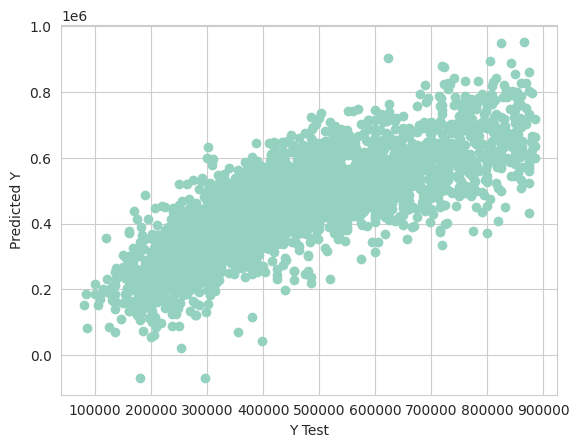

In [110]:
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

### Evaluating the Model

different metrics to measure values

In [111]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
error_score = metrics.r2_score(y_test, predictions)
print(f"R squared Error :{error_score} ")

MAE: 82688.05687903253
MSE: 11222164849.791914
RMSE: 105934.71975604558
R squared Error :0.644151666096316 


mean_absolute_error can help inference from the with the situation. R squared is from 0 to 1, model describes 64% of the data

<ipython-input-95-5f2bc21c0ef7>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test-predictions),bins=50);


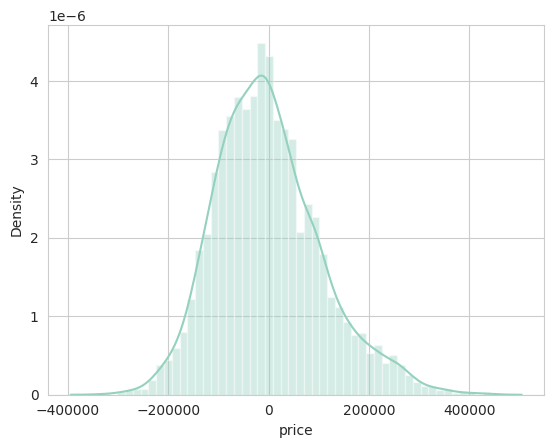

In [95]:
sns.distplot((y_test-predictions),bins=50);

shows error distrubition, showing can be up to 40k to -40k of error

### Regression Model creation by means of statsmodels

In [155]:
X2_train = sm.add_constant(X_train)
X2_test = sm.add_constant(X_test)

In [156]:
model2 = sm.OLS(y_train, X2_train)

In [157]:
model2_ = model2.fit()

In [158]:
print(model2_.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     1291.
Date:                Sat, 18 May 2024   Prob (F-statistic):               0.00
Time:                        05:57:29   Log-Likelihood:            -1.8354e+05
No. Observations:               14145   AIC:                         3.671e+05
Df Residuals:                   14124   BIC:                         3.673e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.642e+07   5.03e+05    -32.636

### Scaling the data

In [116]:
scaler = StandardScaler()

In [117]:
num_col=data_cleaned.columns

In [122]:
data_cleaned_boolean = data_cleaned[boolean_columns]

In [123]:
data_cleaned_boolean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17682 entries, 0 to 21596
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   View0        17682 non-null  int64
 1   View1        17682 non-null  int64
 2   View2        17682 non-null  int64
 3   View3        17682 non-null  int64
 4   View4        17682 non-null  int64
 5   Condition0   17682 non-null  int64
 6   Condition1   17682 non-null  int64
 7   Condition2   17682 non-null  int64
 8   Condition3   17682 non-null  int64
 9   Condition4   17682 non-null  int64
 10  waterfront0  17682 non-null  int64
 11  waterfront1  17682 non-null  int64
dtypes: int64(12)
memory usage: 1.8 MB


In [124]:
num_columns = [col for col in data_cleaned.columns if col not in boolean_columns]

In [126]:
data_cleaned_numerical = data_cleaned[num_columns]

In [146]:
new_data = pd.DataFrame(scaler.fit_transform(data_cleaned_numerical.values), columns= data_cleaned_numerical.columns)

In [135]:
#new_data = pd.merge(new_data,data_cleaned_boolean, left_index = True, right_index = True )

In [147]:
new_data

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,sqft_basement,lat,long,sqft_living15,sqft_lot15
0,-1.259199,-0.320493,-1.449860,-0.997111,-0.455601,-0.852156,-0.437232,-0.666549,-0.655728,-0.327825,-0.227363,-0.897643,-0.366766
1,0.536386,-0.320493,0.369152,1.030137,-0.029250,0.996997,-0.437232,0.866614,0.379887,1.167719,-0.687597,-0.261929,0.062360
2,-1.497209,-1.424516,-1.449860,-1.595076,0.709367,-0.852156,-1.514893,-1.301496,-0.655728,1.288189,-0.049208,1.608889,0.153621
3,0.911295,0.783530,1.460559,0.140482,-0.629677,-0.852156,-0.437232,-0.867874,1.700297,-0.259392,-1.236909,-0.861317,-0.507003
4,0.377334,-0.320493,0.005349,-0.267885,0.195174,-0.852156,0.640429,0.107776,-0.655728,0.424937,1.346340,-0.062132,0.033018
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17677,-0.474731,-0.320493,0.732954,-0.486653,-1.665828,2.846151,0.640429,-0.124522,-0.655728,1.013032,-0.888022,-0.552541,-1.260183
17678,-0.247514,0.783530,0.732954,0.650940,-0.411948,0.996997,0.640429,1.083425,-0.655728,-0.331389,-1.006792,-0.007643,-0.032354
17679,-0.235579,-1.424516,-1.813662,-1.230463,-1.607178,0.996997,-0.437232,-0.914333,-0.655728,0.265260,-0.539135,-1.478868,-1.152740
17680,-0.247514,-0.320493,0.732954,-0.384561,-1.329193,0.996997,0.640429,-0.016116,-0.655728,-0.161733,1.168185,-0.770500,-1.308079


In [148]:
Y_new = new_data['price']
X_new = new_data.drop(['price'],axis=1)

In [149]:
from sklearn.model_selection import train_test_split
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_new, Y_new, test_size=0.2, random_state=10)

In [150]:
lm = LinearRegression()
lm.fit(X_new_train,y_new_train)

LinearRegression()

In [151]:
print('Coefficients: \n', lm.coef_)

Coefficients: 
 [-0.01563873 -0.03873425  0.19009979 -0.07615972 -0.03945612  0.27295799
  0.13915164  0.1048302   0.44388519 -0.05165218  0.16468133 -0.02889412]


In [152]:
predictions = lm.predict( X_new_test)

Text(0, 0.5, 'Predicted Y')

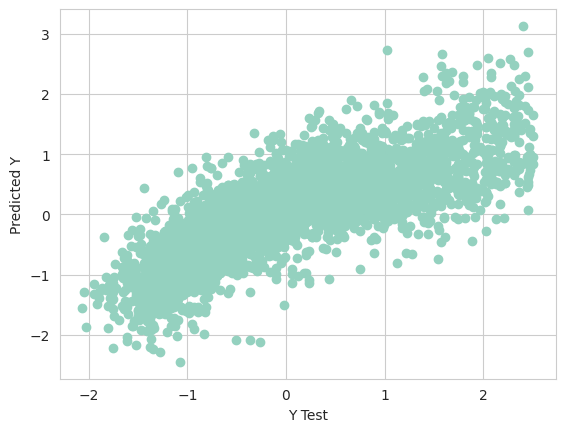

In [153]:
plt.scatter(y_new_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [154]:
print('MAE:', metrics.mean_absolute_error(y_new_test, predictions))
print('MSE:', metrics.mean_squared_error(y_new_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_new_test, predictions)))
error_score = metrics.r2_score(y_new_test, predictions)
print(f"R squared Error :{error_score} ")

MAE: 0.4890608164881751
MSE: 0.39285179059715397
RMSE: 0.6267789008870305
R squared Error :0.6139404806296527 


### As the next steps can be considered outliers exclusion in addition and after it to exclude the not significant variables from the models